# DỰ ĐOÁN GIÁ TRỊ CẦU THỦ - XGBOOST MODEL

**Model:** XGBoost Regression | **Validation:** Train/Val/Test + 5-Fold CV | **Metrics:** R², MSE, RMSE, MAE

## 1. IMPORT & SETUP

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Setup Complete | Model: XGBoost')

Setup Complete | Model: XGBoost


## 2. LOAD DATA

In [17]:
df = pd.read_csv('football_players_dataset.csv')
print(f'Shape: {df.shape} | Missing: {df.isnull().sum().sum()}')
print(f'\nTarget Stats:\nMean: €{df["market_value"].mean():.2f}M | Skew: {df["market_value"].skew():.2f}')
display(df.head())

Shape: (16453, 46) | Missing: 330

Target Stats:
Mean: €3.33M | Skew: 7.47


,age,nationality,position,position_category,current_club,league,appearances,minutes_played,is_GK,is_DF,...,passes_received_per90,interceptions_per90,blocks_per90,ball_recoveries_per90,aerials_won_per90,yellow_cards_per90,fouls_committed_per90,calculated_mpg,calculated_sum,market_value
0,23.0,New Zealand,GK,GK,Auckland FC,A-League Men,26,2340,1,0,...,0.000,0.00,0.00,0.00,0.00,0.00,0.00,90.000000,0.00,0.75
1,27.0,Uruguay,FW,FW,Auckland FC,A-League Men,26,2268,0,0,...,28.280,0.48,0.81,3.55,2.59,0.00,2.10,87.230769,0.33,0.75
2,31.0,New Zealand,DF,DF,Auckland FC,A-League Men,26,2198,0,1,...,34.055,1.09,1.14,4.11,1.43,0.20,1.03,84.538462,0.00,0.60
3,26.0,New Zealand,DF,DF,Auckland FC,A-League Men,25,2142,0,1,...,34.055,1.09,1.14,4.11,1.43,0.20,1.03,85.680000,0.00,0.45
4,35.0,Japan,DF-MF,DF,Auckland FC,A-League Men,23,2024,0,1,...,38.170,2.00,1.33,3.00,2.83,0.17,1.00,88.000000,0.00,0.50


## 3. TARGET VISUALIZATION

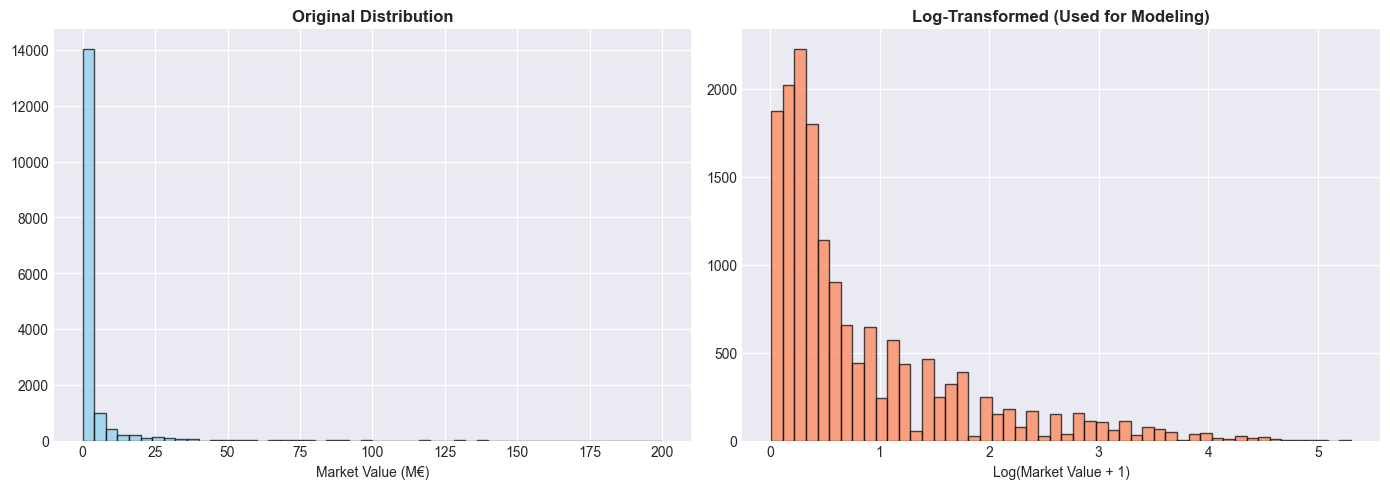

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['market_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Original Distribution', fontweight='bold')
axes[0].set_xlabel('Market Value (M€)')

axes[1].hist(np.log1p(df['market_value']), bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_title('Log-Transformed (Used for Modeling)', fontweight='bold')
axes[1].set_xlabel('Log(Market Value + 1)')

plt.tight_layout()
plt.savefig('xgb_target.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. FEATURE ENGINEERING

In [19]:
df_feat = df.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Log transform skewed features
exclude = ['market_value', 'is_GK', 'is_DF', 'is_MF', 'is_FW']
for col in numeric_cols:
    if col not in exclude and abs(df_feat[col].skew()) > 1.0:
        df_feat[f'{col}_log'] = np.log1p(df_feat[col])

# Ratio features
if 'goals' in df_feat.columns and 'shots_per90' in df_feat.columns:
    df_feat['goals_per_shot'] = df_feat['goals'] / df_feat['shots_per90'].replace(0, 0.01)
if 'passes_completed_per90' in df_feat.columns and 'pass_completion_pct' in df_feat.columns:
    df_feat['pass_efficiency'] = df_feat['passes_completed_per90'] * df_feat['pass_completion_pct'] / 100
if 'goals' in df_feat.columns and 'assists' in df_feat.columns:
    df_feat['goal_contributions'] = df_feat['goals'] + df_feat['assists']

# Interaction features
df_feat['age_experience'] = df_feat['age'] * np.log1p(df_feat['minutes_played'])
if 'minutes_played' in df_feat.columns and 'appearances' in df_feat.columns:
    df_feat['minutes_per_game'] = df_feat['minutes_played'] / df_feat['appearances'].replace(0, 1)

# Polynomial features
for feat in ['goals', 'assists', 'minutes_played']:
    if feat in df_feat.columns:
        df_feat[f'{feat}_squared'] = df_feat[feat] ** 2

# Categorical encoding
for col in ['nationality', 'current_club']:
    if col in df_feat.columns:
        target_mean = df_feat.groupby(col)['market_value'].mean()
        df_feat[f'{col}_target_enc'] = df_feat[col].map(target_mean).fillna(df_feat['market_value'].mean())

le = LabelEncoder()
for col in ['position', 'league']:
    if col in df_feat.columns:
        df_feat[f'{col}_label_enc'] = le.fit_transform(df_feat[col].astype(str))

for col in ['nationality', 'position', 'current_club', 'league']:
    if col in df_feat.columns:
        freq = df_feat[col].value_counts()
        df_feat[f'{col}_freq'] = df_feat[col].map(freq)

print(f'Features: {len(df.columns)} → {len(df_feat.columns)}')

Features: 46 → 79


## 5. FEATURE SELECTION

Top 20 Features:
 1. current_club_target_enc                       0.6028
 2. goal_contributions                            0.2854
 3. calculated_sum                                0.2704
 4. calculated_sum_log                            0.2691
 5. goals                                         0.2567
 6. goals_squared                                 0.2474
 7. nationality_target_enc                        0.2450
 8. assists                                       0.2418
 9. goals_log                                     0.2198
10. assists_log                                   0.2166
11. assists_squared                               0.2152
12. minutes_played_squared                        0.2038
13. minutes_played                                0.2027
14. appearances                                   0.2005
15. gca_per90                                     0.1861
16. gca_per90_log                                 0.1802
17. progressive_carries_per90                     0.1787
18. xag_per90 

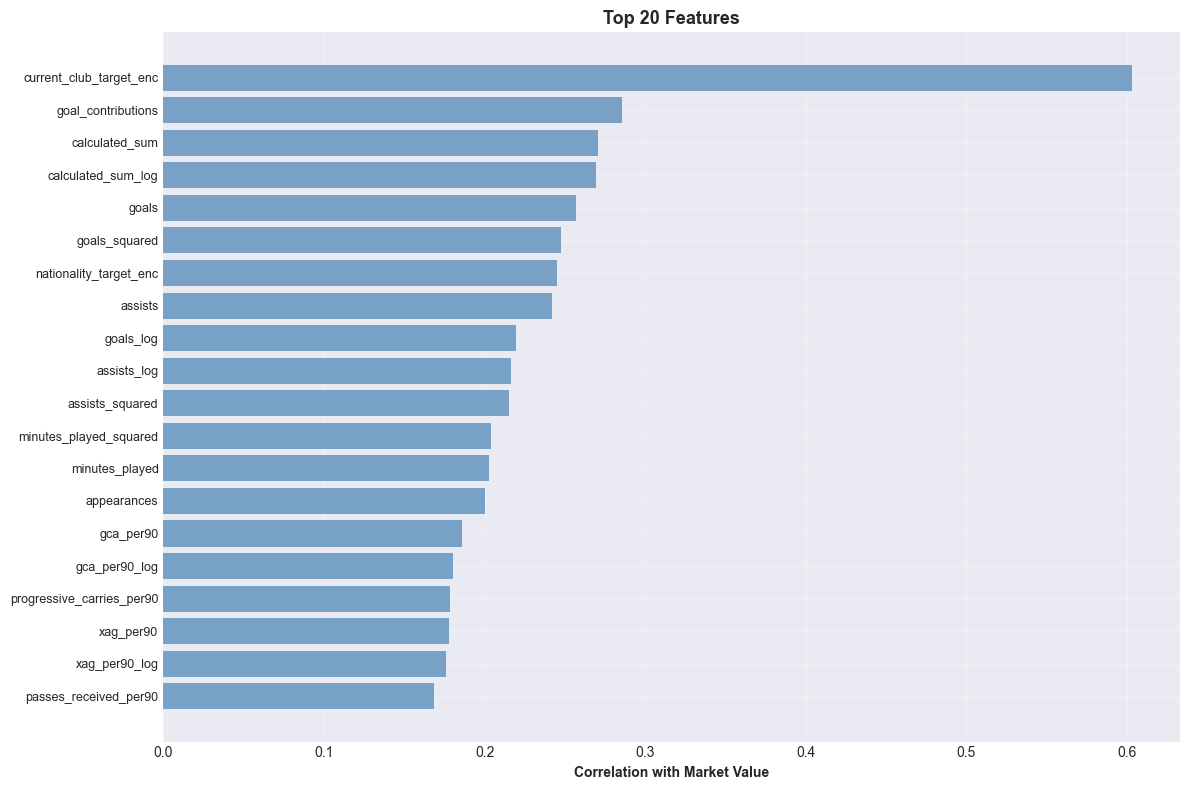

In [21]:
exclude_cols = ['market_value', 'position_category', 'nationality', 'position', 'current_club', 'league']
feature_cols = [col for col in df_feat.columns 
                if col not in exclude_cols and df_feat[col].dtype in ['int64', 'float64']]

X_temp = df_feat[feature_cols].fillna(0)
y_temp = df_feat['market_value']

correlations = {col: abs(X_temp[col].corr(y_temp)) for col in feature_cols}
sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print('Top 20 Features:')
for i, (feat, corr) in enumerate(sorted_corr[:20], 1):
    print(f'{i:2d}. {feat:<45} {corr:.4f}')

selected_features = [f for f, c in correlations.items() if c > 0.05]
print(f'\nSelected: {len(selected_features)} features')

# Visualization
plt.figure(figsize=(12, 8))
top_20 = [f for f, _ in sorted_corr[:20]]
top_20_corr = [c for _, c in sorted_corr[:20]]
plt.barh(range(len(top_20)), top_20_corr, alpha=0.7, color='steelblue')
plt.yticks(range(len(top_20)), top_20, fontsize=9)
plt.xlabel('Correlation with Market Value', fontweight='bold')
plt.title('Top 20 Features', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_features.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. DATA PREPARATION

In [22]:
# Remove outliers
Q1, Q3 = df_feat['market_value'].quantile([0.01, 0.99])
df_clean = df_feat[(df_feat['market_value'] >= Q1) & (df_feat['market_value'] <= Q3)]
print(f'Outliers removed: {len(df_feat) - len(df_clean)} ({(1-len(df_clean)/len(df_feat))*100:.1f}%)')

X = df_clean[selected_features].fillna(0)
y_log = np.log1p(df_clean['market_value'])

# Three-way split: Train (64%), Val (16%), Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(f'\nTrain: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print('Scaling complete')

Outliers removed: 187 (1.1%)

Train: 10,409 | Val: 2,603 | Test: 3,254
Scaling complete


## 7. BASELINE XGBOOST MODEL

In [24]:
baseline_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Metrics
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred)))
test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred))

# Cross-validation
cv_scores = cross_val_score(baseline_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print('\n- BASELINE MODEL PERFORMANCE')
print(f'CV R² (5-fold):  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'Validation R²:   {val_r2:.4f}')
print(f'Test R²:         {test_r2:.4f}')
print(f'Test RMSE:       €{test_rmse:.2f}M')
print(f'Test MAE:        €{test_mae:.2f}M')


- BASELINE MODEL PERFORMANCE
CV R² (5-fold):  0.7802 ± 0.0128
Validation R²:   0.7764
Test R²:         0.7776
Test RMSE:       €3.21M
Test MAE:        €1.19M


## 8. HYPERPARAMETER TUNING

In [ ]:
param_grid = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 6, 7],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print('- Grid Search in progress...')
grid_search.fit(X_train_scaled, y_train)

print('\n- BEST PARAMETERS:')
for param, value in grid_search.best_params_.items():
    print(f'   {param}: {value}')
print(f'\n- Best CV Score: {grid_search.best_score_:.4f}')

# Evaluate tuned model
best_model = grid_search.best_estimator_
y_val_tuned = best_model.predict(X_val_scaled)
y_test_tuned = best_model.predict(X_test_scaled)

val_r2_tuned = r2_score(y_val, y_val_tuned)
test_r2_tuned = r2_score(y_test, y_test_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_tuned)))
test_mae_tuned = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_tuned))

print('\n- TUNED MODEL PERFORMANCE')
print(f'Validation R²:   {val_r2_tuned:.4f}')
print(f'Test R²:         {test_r2_tuned:.4f}')
print(f'Test RMSE:       €{test_rmse_tuned:.2f}M')
print(f'Test MAE:        €{test_mae_tuned:.2f}M')
print(f'\nImprovement:     {((test_r2_tuned - test_r2)/test_r2)*100:+.2f}%')

⏳ Grid Search in progress...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

🏆 BEST PARAMETERS:
   colsample_bytree: 0.9
   learning_rate: 0.07
   max_depth: 5
   min_child_weight: 4
   n_estimators: 250
   subsample: 0.9

Best CV Score: 0.7828

📊 TUNED MODEL PERFORMANCE
Validation R²:   0.7773
Test R²:         0.7802
Test RMSE:       €3.18M
Test MAE:        €1.18M

Improvement:     +0.33%


## 9. MODEL EVALUATION

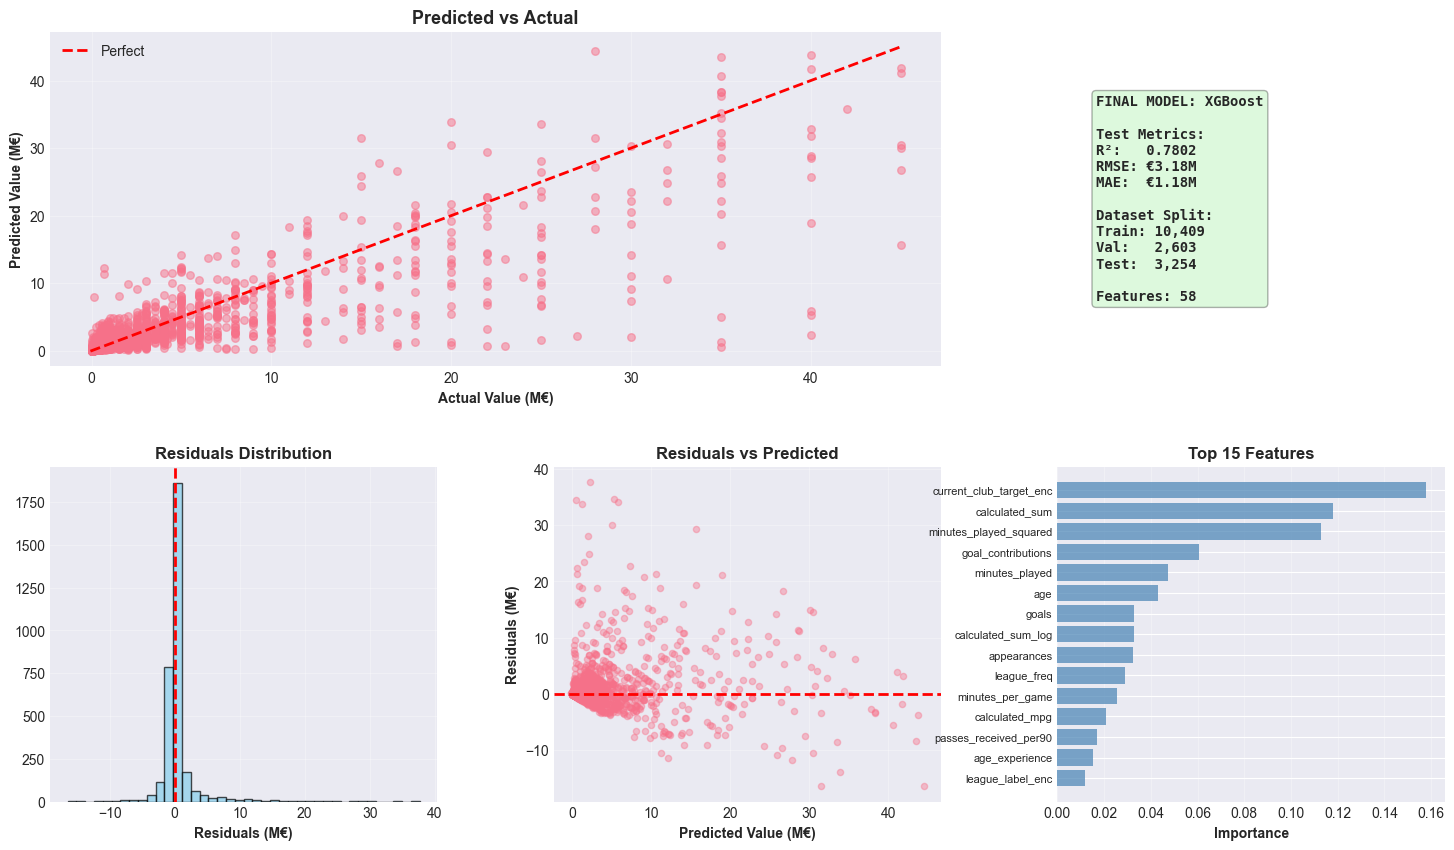


Residuals Analysis:
Mean:   €0.40M
Std:    €3.16M
Median: €-0.06M


In [ ]:
y_pred_final = np.expm1(y_test_tuned)
y_actual = np.expm1(y_test)
residuals = y_actual - y_pred_final

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Predicted vs Actual
ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(y_actual, y_pred_final, alpha=0.5, s=30)
min_val, max_val = min(y_actual.min(), y_pred_final.min()), max(y_actual.max(), y_pred_final.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
ax1.set_xlabel('Actual Value (M€)', fontweight='bold')
ax1.set_ylabel('Predicted Value (M€)', fontweight='bold')
ax1.set_title('Predicted vs Actual', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Metrics box
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
metrics_text = f'''FINAL MODEL: XGBoost

Test Metrics:
R²:   {test_r2_tuned:.4f}
RMSE: €{test_rmse_tuned:.2f}M
MAE:  €{test_mae_tuned:.2f}M

Dataset Split:
Train: {len(X_train):,}
Val:   {len(X_val):,}
Test:  {len(X_test):,}

Features: {len(selected_features)}'''
ax2.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3),
         fontweight='bold', family='monospace')

# Residuals distribution
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(residuals, bins=40, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', lw=2)
ax3.set_xlabel('Residuals (M€)', fontweight='bold')
ax3.set_title('Residuals Distribution', fontweight='bold')
ax3.grid(alpha=0.3)

# Residuals vs Predicted
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_pred_final, residuals, alpha=0.4, s=20)
ax4.axhline(0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Value (M€)', fontweight='bold')
ax4.set_ylabel('Residuals (M€)', fontweight='bold')
ax4.set_title('Residuals vs Predicted', fontweight='bold')
ax4.grid(alpha=0.3)

# Feature importance
ax5 = fig.add_subplot(gs[1, 2])
importances = best_model.feature_importances_
indices = np.argsort(importances)[-15:]
ax5.barh(range(len(indices)), importances[indices], alpha=0.7, color='steelblue')
ax5.set_yticks(range(len(indices)))
ax5.set_yticklabels([selected_features[i] for i in indices], fontsize=8)
ax5.set_xlabel('Importance', fontweight='bold')
ax5.set_title('Top 15 Features', fontweight='bold')
ax5.grid(alpha=0.3, axis='x')

plt.savefig('xgb_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n- Residuals Analysis:')
print(f'Mean:   €{residuals.mean():.2f}M')
print(f'Std:    €{residuals.std():.2f}M')
print(f'Median: €{np.median(residuals):.2f}M')

## 10. SAVE MODEL & RESULTS

In [ ]:
# Save model and components
joblib.dump(best_model, 'xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'features.pkl')

# Save metadata
metadata = {
    'model': 'XGBoost',
    'n_features': len(selected_features),
    'n_train': len(X_train),
    'n_val': len(X_val),
    'n_test': len(X_test),
    'test_r2': test_r2_tuned,
    'test_rmse': test_rmse_tuned,
    'test_mae': test_mae_tuned,
    'best_params': grid_search.best_params_,
    'cv_score': grid_search.best_score_
}
joblib.dump(metadata, 'metadata.pkl')

# Final report
report = f'''{'='*60}
XGBOOST MODEL - FINAL REPORT
{'='*60}

DATASET
Total:    {len(df):,} samples
Cleaned:  {len(df_clean):,} samples
Features: {len(selected_features)}

DATA SPLIT
Train:      {len(X_train):,} ({len(X_train)/len(df_clean)*100:.1f}%)
Validation: {len(X_val):,} ({len(X_val)/len(df_clean)*100:.1f}%)
Test:       {len(X_test):,} ({len(X_test)/len(df_clean)*100:.1f}%)

PERFORMANCE METRICS
Cross-Validation R²: {grid_search.best_score_:.4f}
Test R²:             {test_r2_tuned:.4f}
Test RMSE:           €{test_rmse_tuned:.2f}M
Test MAE:            €{test_mae_tuned:.2f}M

BEST HYPERPARAMETERS
''' + '\n'.join([f'{k}: {v}' for k, v in grid_search.best_params_.items()]) + f'''

OUTPUT FILES
✓ xgb_target.png
✓ xgb_features.png
✓ xgb_evaluation.png
✓ xgboost_model.pkl
✓ scaler.pkl
✓ features.pkl
✓ metadata.pkl

{'='*60}
PROJECT COMPLETE
{'='*60}'''

print(report)
with open('xgboost_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print('\nAll files saved successfully!')

XGBOOST MODEL - FINAL REPORT

DATASET
Total:    16,453 samples
Cleaned:  16,266 samples
Features: 58

DATA SPLIT
Train:      10,409 (64.0%)
Validation: 2,603 (16.0%)
Test:       3,254 (20.0%)

PERFORMANCE METRICS
Cross-Validation R²: 0.7828
Test R²:             0.7802
Test RMSE:           €3.18M
Test MAE:            €1.18M

BEST HYPERPARAMETERS
colsample_bytree: 0.9
learning_rate: 0.07
max_depth: 5
min_child_weight: 4
n_estimators: 250
subsample: 0.9

OUTPUT FILES
✓ xgb_target.png
✓ xgb_features.png
✓ xgb_evaluation.png
✓ xgboost_model.pkl
✓ scaler.pkl
✓ features.pkl
✓ metadata.pkl

PROJECT COMPLETE

All files saved successfully!
